# CONFIGURATION:

In [1]:
from jaad_data import JAAD
import torch
from PIL import Image
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
import network
import openpose
from openpose import model
from openpose import util
from openpose.body import Body
import copy

import pickle
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import torch.nn.functional as F

In [2]:
JAAD_PATH = '../JAAD'
DEEPLAB_PATH = '../best_deeplabv3plus_resnet101_cityscapes_os16.pth'
SUBSET_PATH = '../subset'
FILENAME_SUB = '../masks_results_sub.pkl'
FILENAME_BIG = '../masks_results_big.pkl'
POSE_PATH = '../body_pose_model.pth'   


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.cuda.empty_cache()


cuda


In [4]:
RUN =False

# DATASET

In [5]:
# Load the JAAD dataset
jaad_dt = JAAD(data_path=SUBSET_PATH)
#jaad.generate_database()
#jaad_dt.get_data_stats()

data_opts = {
    'fstride': 10,
    'sample_type': 'beh'
}

seq_train = jaad_dt.generate_data_trajectory_sequence('train', **data_opts)  
seq_test = jaad_dt.generate_data_trajectory_sequence('test', **data_opts)  

---------------------------------------------------------
Generating action sequence data
fstride: 10
sample_type: beh
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
---------------------------------------------------------
Generating database for jaad
jaad database loaded from c:\Users\jacop\Documents\ComputerVision\subset\data_cache\jaad_database.pkl
---------------------------------------------------------
Generating intention data
Split: train
Number of pedestrians: 4 
Total number of samples: 2 
---------------------------------------------------------
Generating action sequence data
fstride: 10
sample_type: beh
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}


In [6]:
print('Train sequences:', len(seq_train['image'][0][0]))

Train sequences: 37


In [7]:
""" class JAADDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        self.seq_data = seq_data
        self.transform = transform

    def __len__(self):
        return len(self.seq_data['image'])

    def __getitem__(self, idx):
        # Carica le immagini e le maschere
        print("ciao1")
        img_paths = self.seq_data['image'][idx]

        images = [Image.open(img_path).convert("RGB") for img_path in img_paths]
        print("ciao2")

        #mask_paths = self.seq_data['masks'][idx]
        print("ciao3")

        #masks = [Image.fromarray(mask.numpy()) for mask in mask_paths]
        print("ciao4")
        if self.transform:
            images = [self.transform(img) for img in images]
            #masks = [self.transform(mask) for mask in masks]

        # Carica i metadati
        #pid = torch.tensor(self.seq_data['pid'][idx], dtype=torch.string)
        print(len(images))
        bboxes = torch.tensor(self.seq_data['bbox'][idx], dtype=torch.float32)
        centers = torch.tensor(self.seq_data['center'][idx], dtype=torch.float32)
        occlusions = torch.tensor(self.seq_data['occlusion'][idx], dtype=torch.float32)
        intents = torch.tensor(self.seq_data['intent'][idx], dtype=torch.long)
        #return images,masks, bboxes, centers, occlusions, intents
        return images, bboxes, centers, occlusions, intents """

' class JAADDataset(Dataset):\n    def __init__(self, seq_data, transform=None):\n        self.seq_data = seq_data\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.seq_data[\'image\'])\n\n    def __getitem__(self, idx):\n        # Carica le immagini e le maschere\n        print("ciao1")\n        img_paths = self.seq_data[\'image\'][idx]\n\n        images = [Image.open(img_path).convert("RGB") for img_path in img_paths]\n        print("ciao2")\n\n        #mask_paths = self.seq_data[\'masks\'][idx]\n        print("ciao3")\n\n        #masks = [Image.fromarray(mask.numpy()) for mask in mask_paths]\n        print("ciao4")\n        if self.transform:\n            images = [self.transform(img) for img in images]\n            #masks = [self.transform(mask) for mask in masks]\n\n        # Carica i metadati\n        #pid = torch.tensor(self.seq_data[\'pid\'][idx], dtype=torch.string)\n        print(len(images))\n        bboxes = torch.tensor(self.seq_data[\'

In [8]:
class JAADDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        self.seq_data = seq_data
        self.transform = transform

    def __len__(self):
        return len(self.seq_data['image'])

    def __getitem__(self, idx):
        # Carica le immagini e le maschere
        print("ciao1")
        #get path of images
        img_paths = self.seq_data['image'][idx]
        #get bboxes 
        bbox_sequence = self.seq_data['bbox'][idx]
        masks = self.seq_data['masks'][idx]
        
        #open the images from the paths 
        images = [Image.open(img_path).convert("RGB") for img_path in img_paths]
        print("ciao2")

        #compute local context cropping images arroun the bboxes
        cropped_images = [crop_image(img, bbox) for img, bbox in zip(images, bbox_sequence)]

        #mask_paths = self.seq_data['masks'][idx]
        print("ciao3")

        #masks = [Image.fromarray(mask.numpy()) for mask in mask_paths]
        print("ciao4")
        if self.transform:
            #images = [self.transform(img) for img in images]
            cropped_images = [self.transform(img) for img in cropped_images]

            #masks = [self.transform(mask) for mask in masks]

        # Carica i metadati
        #pid = torch.tensor(self.seq_data['pid'][idx], dtype=torch.string)
        print(len(images))
        print(len(cropped_images))
        bboxes = torch.tensor(self.seq_data['bbox'][idx], dtype=torch.float32)

        intents = torch.tensor(self.seq_data['intent'][idx], dtype=torch.long)
        #return images,masks, bboxes, centers, occlusions, intents
        return  cropped_images, bboxes, intents,masks

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  # Ridimensiona le immagini a 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
# Trasformazioni per le immagini
transform_lc = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# GLOBAL CONTEXT EXTRACTION:

In [11]:
""" deeplab_model = models.segmentation.deeplabv3_resnet101(pretrained=True).to(device)
deeplab_model.eval()  # Imposta il modello in modalità di valutazione """
#deeplab_model = models.segmentation.deeplabv3_resnet101(pretrained=True)
if RUN:
    deeplab_model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=19)
    deeplab_model.load_state_dict(torch.load(DEEPLAB_PATH)['model_state'])
    deeplab_model.to(device)
    deeplab_model.eval()

In [12]:
def get_segmentation_mask(image_path, model, preprocess):
    # Load the image
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(input_image).to(device)
    input_batch = input_tensor.unsqueeze(0)  # Create a batch with a single image
    
    # Pass the image through the model
    with torch.no_grad():
        output = model(input_batch)
        
    # Check if output is a tensor or a dictionary
    if isinstance(output, dict):
        output = output['out'][0]
    elif isinstance(output, torch.Tensor):
        output = output[0]
    else:
        raise ValueError(f"Unexpected output type: {type(output)}")
    
    # Convert the output to a mask
    output_predictions = output.argmax(0)
    # Aggiungi una dimensione batch e canale alla maschera per il ridimensionamento
    output_predictions = output_predictions.unsqueeze(0).unsqueeze(0).float()

    # Ridimensiona la maschera a 224x224
    resized_mask = F.interpolate(output_predictions, size=(224, 224), mode='nearest')

    # Rimuovi le dimensioni batch e canale
    resized_mask = resized_mask.squeeze(0).squeeze(0).long().cpu()
    print(resized_mask.shape)
    plt.imshow(resized_mask)
    plt.show()

    return resized_mask

In [13]:
def process_video_frames(seq_train, model, preprocess):
    all_masks = []
    for video_frames in seq_train['image']:
        video_masks = []

        for frame_path in video_frames:
            mask = get_segmentation_mask(frame_path, model, preprocess)
            #visualize_mask(frame_path, mask)
            video_masks.append(mask)
        all_masks.append(video_masks)
    return all_masks

In [14]:
# Visualizza la maschera semantica
def visualize_mask(image_path, mask):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((256, 256))  # Ridimensiona per la visualizzazione
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='jet')
    plt.title("Semantic Mask")
    plt.show()


In [15]:
if RUN:
    all_video_masks = process_video_frames(seq_train, deeplab_model, train_transforms)
    seq_train['masks'] = all_video_masks
    # Apri il file in modalità scrittura binaria e salva il dizionario
    with open(FILENAME_BIG, 'wb') as f:
        pickle.dump(seq_train['masks'], f)
else:
    #recover data:
    with open(FILENAME_SUB, 'rb') as f:
        seq_train['masks'] = pickle.load(f)

    # Verifica che i risultati siano stati caricati correttamente
    print(seq_train['masks'])

[[tensor([[10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), tensor([[10, 10, 10,  ..., 10,  2,  2],
        [10, 10, 10,  ..., 10,  2,  2],
        [10, 10, 10,  ..., 10,  2,  2],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), tensor([[10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), tensor([[10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,

# LOCAL CONTEXT:

In [16]:
# crop frames arround bounding boxes
def crop_image(img, bbox):
    x1, y1, x2, y2 = bbox
    return img.crop((x1, y1, x2, y2))

# POSE KEYPOINTS: 

In [17]:
body_estimation = Body('../body_pose_model.pth')
test_image = 'pic3.png'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset = body_estimation(oriImg)
canvas = copy.deepcopy(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)

c:\Users\jacop\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [18]:
def extract_pose_sequence(frames,body_model):
    pose_sequences = []  # Lista di pose per ciascuna persona nel tempo
    print(type(frames[0]))
    for frame in frames:
        print(type(frame))
        candidate, subset = body_model(frame)
        frame_poses = []
        for person in subset:
            if person[-1] >= 4:  # Almeno 4 punti chiave rilevati
                pose = []
                for i in range(18):
                    if person[i] != -1:
                        x, y = candidate[int(person[i])][:2]
                    else:
                        x, y = -1, -1  # Punti chiave mancanti
                    pose.extend([x, y])
                frame_poses.append(pose)
        
        pose_sequences.append(frame_poses)

    # Trasponi la lista di liste per ottenere le sequenze temporali per ciascuna persona
    # Cioè da [[pose_frame1_person1, pose_frame1_person2, ...], [pose_frame2_person1, pose_frame2_person2, ...], ...]
    # a [[pose_frame1_person1, pose_frame2_person1, ...], [pose_frame1_person2, pose_frame2_person2, ...], ...]
    person_pose_sequences = list(map(list, zip(*pose_sequences)))

    person_pose_sequences = [torch.tensor(person_poses, dtype=torch.float32) for person_poses in person_pose_sequences]
    print(person_pose_sequences)
    return person_pose_sequences
    
# Caricamento del modello
body_model = Body('../body_pose_model.pth')

# Caricamento dei frame (qui puoi sostituire con il tuo metodo di caricamento dei frame)
#frames = [cv2.imread(f'frame_{i}.png') for i in range(num_frames)]
test_image='pic3.png'
# Estrazione delle pose
oriImg = cv2.imread(test_image)  # B,G,R order
pose_sequences = extract_pose_sequence([oriImg],body_model)
# Stampa delle pose per ogni persona
# for i, person_poses in enumerate(pose_sequences):
#     print(f"Person {i + 1} pose sequence:")
#     for pose in person_poses:
#         print(pose)
print((pose_sequences[0]).shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[tensor([[445., 490., 443., 507., 433., 501., 411., 518., 392., 521., 457., 514.,
         449., 535., 423., 532., 418., 575.,  -1.,  -1.,  -1.,  -1., 442., 575.,
         431., 575.,  -1.,  -1., 443., 487., 452., 489., 440., 487., 457., 492.]]), tensor([[706., 519., 713., 543., 691., 546., 687., 575.,  -1.,  -1., 736., 543.,
         751., 575.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1., 701., 515., 711., 514., 694., 521., 715., 517.]]), tensor([[765., 530., 758., 575., 727., 575.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1., 763., 522., 765., 524., 760., 529.,  -1.,  -1.]]), tensor([[608., 510., 571., 543.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1., 610., 575.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1., 599., 499.,  -1., 

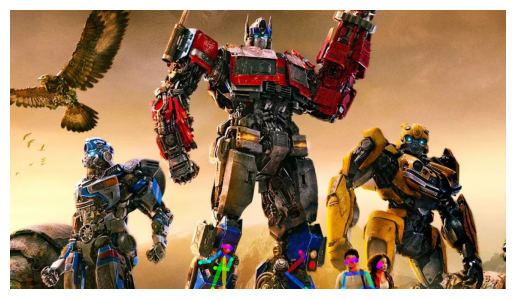

In [19]:

plt.imshow(canvas[:, :, [2, 1, 0]])
plt.axis('off')
plt.show()

# MODEL:

In [20]:
class VisionBranchLocal(torch.nn.Module):
    def __init__(self, vgg16):
        super(VisionBranchLocal, self).__init__()
        self.vgg16 = vgg16
        self.avgpool = torch.nn.AvgPool2d(kernel_size=14)  # Pooling layer con kernel 14x14
        self.gru = torch.nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)  # Output: crossing or not crossing
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Tanh()

    def forward(self, cropped_images):
        seq_len, c, h, w = cropped_images.size()
        
        # Estrai feature dalle immagini con VGG19
        vgg_features = []
        for i in range(seq_len):            

            img = cropped_images[i]            
            vgg_feat_img = self.vgg16.features(img)
            pooled_feat_img = self.avgpool(vgg_feat_img)  # Applica il pooling
            vgg_feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)  # Flatten features
            vgg_features.append(vgg_feat_img)
        
        vgg_features = torch.stack(vgg_features, dim=1).permute(2,1,0)
        #vgg_features = vgg_features.flatten(start_dim=2)
        # Combina con i metadati

        # metadatas = torch.cat((bboxes, centers, occlusions), dim=-1)
        # features = torch.cat((vgg_features, metadatas), dim=-1)
        
        # # Passa attraverso la GRU
#        out = vgg_features
        print("SIZE:",vgg_features.shape)
        gru_out, _ = self.gru(vgg_features)
        print("SIZE:",gru_out.shape)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        print("SIZE:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        print("SIZE:",context_vector.shape)
        #out = self.sigmoid(self.fc(gru_out[:, -1, :]))   
        out = self.tanh((context_vector))
        return out


In [21]:
class VisionBranchGlobal(torch.nn.Module):
    def __init__(self, vgg16):
        super(VisionBranchGlobal, self).__init__()
        self.vgg16 = vgg16
        self.avgpool = torch.nn.AvgPool2d(kernel_size=14)  # Pooling layer con kernel 14x14
        self.gru = torch.nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)  # Output: crossing or not crossing
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Tanh()

    def forward(self, masks):
        seq_len, c, h, w = masks.size()
        
        # Estrai feature dalle immagini con VGG19
        vgg_features = []
        for i in range(seq_len):            

            img = masks[i]            
            vgg_feat_img = self.vgg16.features(img)
            pooled_feat_img = self.avgpool(vgg_feat_img)  # Applica il pooling
            vgg_feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)  # Flatten features
            vgg_features.append(vgg_feat_img)
        
        vgg_features = torch.stack(vgg_features, dim=1).permute(2,1,0)
        #vgg_features = vgg_features.flatten(start_dim=2)
        # Combina con i metadati

        # metadatas = torch.cat((bboxes, centers, occlusions), dim=-1)
        # features = torch.cat((vgg_features, metadatas), dim=-1)
        
        # # Passa attraverso la GRU
#        out = vgg_features
        print("SIZE:",vgg_features.shape)
        gru_out, _ = self.gru(vgg_features)
        print("SIZE:",gru_out.shape)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        print("SIZE:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        print("SIZE:",context_vector.shape)
        #out = self.sigmoid(self.fc(gru_out[:, -1, :]))   
        out = self.tanh((context_vector))
        return out


In [22]:
class NVisionBranch(torch.nn.Module):
    def __init__(self,size):
        super(NVisionBranch, self).__init__()
        self.gru = torch.nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.gru2 = torch.nn.GRU(input_size=256+size, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)  # Output: crossing or not crossing
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Tanh()

    def forward(self, pose,bbox):
        gru_out, _ = self.gru(pose)
        print("SIZE:",gru_out.shape)
        LP = torch.cat(gru_out,bbox)
        gru_out, _ = self.gru2(LP)
        print("SIZE:",gru_out.shape)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        print("SIZE:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        print("SIZE:",context_vector.shape)
        #out = self.sigmoid(self.fc(gru_out[:, -1, :]))   
        out = self.tanh((context_vector))
        return out


In [ ]:
class PedestrianIntentModel(torch.nn.Module):
    def __init__(self, vision_branch_local,vision_branch_global,non_vision_branch):
        super(PedestrianIntentModel, self).__init__()
        self.vision_branch_local = vision_branch_local
        self.vision_branch_global = vision_branch_global
        self.non_vision_branch = non_vision_branch
        self.fc = torch.nn.Linear(256, 2) # Output: crossing or not crossing
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, cropped_images, bboxes,masks,poses):
        vision_out_local = self.vision_branch_local(cropped_images)
        vision_out_global = self.vision_branch_global(masks)
        non_vision_out = self.non_vision_branch(poses,bboxes)

        vision_out = torch.cat((vision_out_local, vision_out_global), dim=-1)
        final_fusion = torch.cat((vision_out, non_vision_out), dim=-1)

        attn_weights = torch.softmax(self.attn(final_fusion), dim=1)
        print("SIZE:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * final_fusion, dim=1)

        out = self.sigmoid(self.fc(context_vector))
        return out

In [23]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# class PedestrianIntentModel(nn.Module):
#     def __init__(self, vgg16):
#         super(PedestrianIntentModel, self).__init__()
#         self.vgg16 = vgg16
        
#         # Shared pooling layer
#         self.avgpool = nn.AvgPool2d(kernel_size=14)
        
#         # Local context branch
#         self.gru_local = nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
#         self.attn_local = nn.Linear(256, 1)
        
#         # Global context branch
#         self.gru_global = nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
#         self.attn_global = nn.Linear(256, 1)
        
#         # Final prediction layer
#         self.fc = nn.Linear(256 * 2, 2)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, local_images, global_images):
#         seq_len, c, h, w = local_images.size()
        
#         # Extract features from local images using VGG16
#         local_features = []
#         for i in range(seq_len):
#             img = local_images[i]
#             feat_img = self.vgg16.features(img)
#             pooled_feat_img = self.avgpool(feat_img)
#             feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)
#             local_features.append(feat_img)
#         local_features = torch.stack(local_features, dim=1).permute(0, 1, 2)
        
#         # Pass through GRU and apply attention in the local context branch
#         gru_local_out, _ = self.gru_local(local_features)
#         attn_local_weights = torch.softmax(self.attn_local(gru_local_out), dim=1)
#         context_local = torch.sum(attn_local_weights * gru_local_out, dim=1)
        
#         # Extract features from global images using VGG16
#         global_features = []
#         for i in range(seq_len):
#             img = global_images[i]
#             feat_img = self.vgg16.features(img)
#             pooled_feat_img = self.avgpool(feat_img)
#             feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)
#             global_features.append(feat_img)
#         global_features = torch.stack(global_features, dim=1).permute(0, 1, 2)
        
#         # Pass through GRU and apply attention in the global context branch
#         gru_global_out, _ = self.gru_global(global_features)
#         attn_global_weights = torch.softmax(self.attn_global(gru_global_out), dim=1)
#         context_global = torch.sum(attn_global_weights * gru_global_out, dim=1)
        
#         # Concatenate the context vectors from both branches
#         combined_context = torch.cat((context_local, context_global), dim=-1)
        
#         # Final output
#         out = self.sigmoid(self.fc(combined_context))
#         return out

# # Example usage:
# # vgg16 = models.vgg16(pretrained=True)
# # model = PedestrianIntentModel(vgg16)
# # local_images = torch.randn(seq_len, c, h, w)  # Example input for local context
# # global_images = torch.randn(seq_len, c, h, w)  # Example input for global context
# # output = model(local_images, global_images)


In [24]:
class VGG16_FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(VGG16_FeatureExtractor, self).__init__()
        self.features = torch.nn.Sequential(*list(vgg16.features.children())[:24]) # block4_pool è il 23° livello
    
    def forward(self, x):
        x = self.features(x)
        return x

In [25]:
# Carica il modello VGG19 pre-addestrato
vgg16 = models.vgg16(pretrained=True)

vgg16_fe = VGG16_FeatureExtractor()

# # Congela i pesi dei primi strati
# for param in vgg16_fe.parameters():
#     param.requires_grad = False

# # Sostituisci l'ultimo strato della VGG19 per il tuo task specifico
# num_features = vgg16_fe.classifier[6].in_features
# vgg16_fe.classifier[6] = torch.nn.Linear(num_features, 2)  # Assuming 2 classes for intent

# # Abilita il training solo per i nuovi strati aggiunti
# for param in vgg16_fe.classifier[6].parameters():
#     param.requires_grad = True
# # Inizializza il modello con VGG19
model_local = VisionBranchLocal(vgg16_fe).to(device)
model_global = VisionBranchGlobal(vgg16_fe).to(device)

# Definisci la loss e l'ottimizzatore
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
vgg16_fe

c:\Users\jacop\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jacop\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: module 'openpose.model' has no attribute 'parameters'

In [ ]:
# Carica il modello VGG19 pre-addestrato
model2 = models.vgg16(pretrained=True).to(device)

# Definisci la loss e l'ottimizzatore
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# TRAINING:

In [ ]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def show_pic(image):    
    numpy_data = image.cpu().numpy()

    # Create a new figure
    plt.figure(figsize=(8, 8))

    # Display the image
    plt.imshow(numpy_data)  # Use 'gray' colormap for grayscale images

    # Remove axes ticks
    plt.axis('off')

    # Add a title if needed
    plt.title("Your Image Title")

    # Show the plot
    plt.show()

ciao1
ciao2
ciao3
ciao4
37
37
2
ciao1
ciao2
ciao3
ciao4
37
37
tensor([465., 730., 533., 848.])
ciao1
ciao2
ciao3
ciao4
37
37


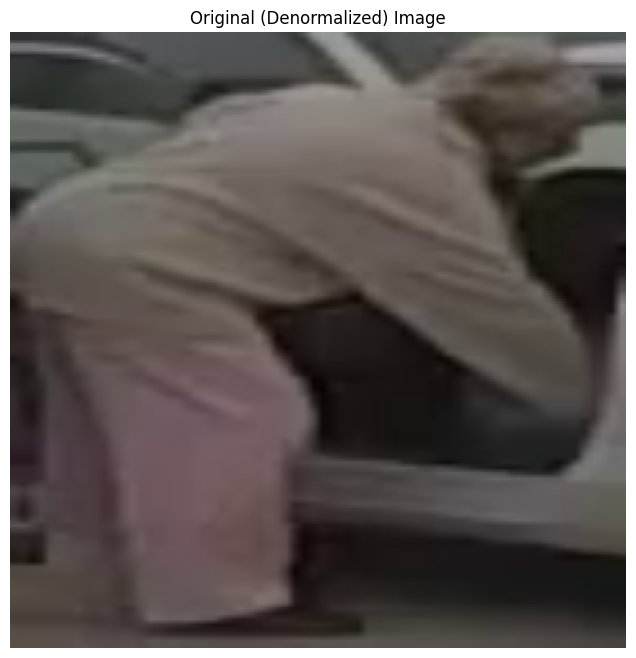

ciao1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..1.1410894].


ciao2
ciao3
ciao4
37
37


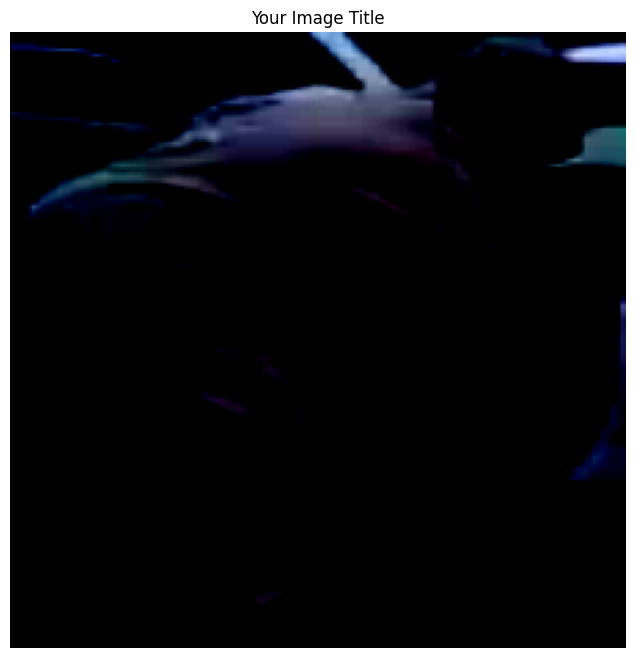

In [ ]:
train_dataset = JAADDataset(seq_train, transform=transform_lc)
(train_dataset.__getitem__(0))
print(len(train_dataset))
print(train_dataset.__getitem__(0)[1][0])
denormalized_tensor = denormalize(train_dataset.__getitem__(0)[0][0].clone(), mean, std)
if denormalized_tensor.dim() == 3:
    img_np = denormalized_tensor.permute(1, 2, 0).cpu().numpy()
elif denormalized_tensor.dim() == 4:
    img_np = denormalized_tensor[0].permute(1, 2, 0).cpu().numpy()

# Clip values to [0, 1] range
img_np = np.clip(img_np, 0, 1)

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
plt.axis('off')
plt.title("Original (Denormalized) Image")
plt.show()
show_pic(train_dataset.__getitem__(0)[0][0].permute(1,2,0))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [ ]:
num_epochs = 10
torch.cuda.empty_cache()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()
    for cropped_images, masks, bboxes, poses, intents in train_loader:
        print("TRAINING:")
        cropped_images = torch.stack(cropped_images, dim=1).squeeze(0).permute(0, 1, 2,3).to(device)  # Converte la lista di immagini in un tensor
        masks = torch.stack(masks, dim=1).squeeze(2).to(device)  # Converte la lista di maschere in un tensor
        bboxes = bboxes.to(device)
        poses = poses.to(device)
        intents = intents.squeeze(0).to(device)
        
    #     bboxes = bboxes.stack(images, dim=1).squeeze(2).to(device)
    #     centers = centers.stack(images, dim=1).squeeze(2).to(device)
    #     occlusions = occlusions.stack(images, dim=1).squeeze(2).to(device)
    #     intents = intents.stack(images, dim=1).squeeze(2).to(device)
        #print(images)
        optimizer.zero_grad()
        outputs = model(cropped_images,bboxes)
        loss = criterion(outputs, intents)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch 1/10
ciao1
ciao2
ciao3
ciao4
18
18
TRAINING:
SIZE: torch.Size([1, 18, 512])
SIZE: torch.Size([1, 18, 256])
SIZE: torch.Size([1, 18, 1])
SIZE: torch.Size([1, 256])


ValueError: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([1, 256])) is deprecated. Please ensure they have the same size.

In [ ]:
def train_model(train_loader, model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            images = batch['image']
            masks = batch['mask']
            intents = batch['intent']

            optimizer.zero_grad()

            outputs = model(images, masks)
            loss = criterion(outputs, intents.unsqueeze(1))

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}')

train_model(train_loader, model, criterion, optimizer, num_epochs=25)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, models, transforms
# from torch.utils.data import DataLoader

# # Step 1: Caricamento delle immagini
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# data_dir = 'path_to_your_data'
# image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x),
#                                           transform=data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
#                              shuffle=True, num_workers=4)
#                for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Step 2: Caricamento del modello VGG16 preaddestrato
# model = models.vgg16(pretrained=True)

# # Step 3: Modifica dell'ultimo layer (fine-tuning)
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, 18)

# model = model.to(device)

# # Step 4: Impostazione della perdita e dell'ottimizzatore
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # Step 5: Addestramento del modello
# def train_model(model, criterion, optimizer, num_epochs=25):
#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             running_loss = 0.0
#             running_corrects = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#     return model

# model_ft = train_model(model, criterion, optimizer, num_epochs=25)
